In [24]:
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
import torch.nn as nn
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

In [122]:
"""
diff = f(z,t) - f(ztilde,t)
g = np.zeros(K)
g[theta < 0.5] = 0.5*diff*((-1)**(ztilde[theta<0.5]))*(1/theta[theta<0.5])
g[theta >= 0.5] = 0.5*diff*((-1)**(ztilde[theta>=0.5]))*(1/(1.0 - theta[theta>=0.5]))
g[ztilde == z] = 0 
    
"""

In [493]:
thetas = torch.Tensor(np.random.uniform(size = z.shape))

In [494]:
z = torch.bernoulli(thetas)

In [519]:
out = torch.zeros(z.shape)

In [520]:
q = np.random.choice(list(range(thetas.shape[1])),size = thetas.shape[0])

In [521]:
out[:,q] = z.sum(axis =1)

In [522]:
out

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [547]:
class ugvc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, thetas, model, x):
        """
        z must be sampled from thetas
        """
        u = torch.Tensor(np.random.uniform(size = thetas.shape))
        z = (u < thetas).int().float()
        z_tilde = (1- u < thetas).int().float()
        
        ctx.z = z.detach()
        ctx.z_tilde = z_tilde.detach()
        ctx.x = x.detach()
        ctx.thetas = thetas.detach()
        ctx.model = model 
        q = np.random.choice(list(range(thetas.shape[1])),size = thetas.shape[0])
        ctx.q = q
        x_hat = model.latent_to_mean(z).detach()
        return model.gauss_loss(x,x_hat)
    @staticmethod
    def backward(ctx, grad_output):
        #get params
        x = ctx.x
        model = ctx.model
        z = ctx.z
        z_tilde = ctx.z_tilde
        thetas = ctx.thetas
        diff = (model.gauss_loss_dim(x,model.latent_to_mean(z).detach()) - model.gauss_loss_dim(x,model.latent_to_mean(z_tilde).detach()))
        grad = 0.5*diff.reshape(-1,1)*((-1)**(z_tilde))
        grad[thetas < 0.5] = grad[thetas < 0.5]*(1/(thetas[thetas<0.5] + 10e-6))
        grad[thetas >=0.5] = grad[thetas >=0.5]*(1/(1.0 + 10e-6 - thetas[thetas>=0.5]))
        grad[z_tilde == z] = 0 
        #
        q = ctx.q
        
        #
        input = z
        out = torch.zeros(input.shape)
        z1 = input.detach().clone()
        z2 = input.detach().clone()
        z1[np.arange(len(z1)),q] = 1
        z2[np.arange(len(z2)),q] = 0
        loss_batched = model.gauss_loss_dim(x,model.latent_to_mean(z1).detach()) - model.gauss_loss_dim(x,model.latent_to_mean(z2).detach())
        out[np.arange(len(out)),q] = loss_batched
        
        hidden_dim = z1.shape[1]
        out = hidden_dim*out
        thres = 2*hidden_dim #change threshold here
        
        grad[thetas < 1/thres] = out[thetas < 1/thres] 
        grad[thetas > (thres- 1)/(thres)] = out[thetas > (thres - 1)/(thres)]
        #print(((thetas < 1/(thres))|(thetas > (thres - 1)/(thres))).float().mean())
        return grad, None, None

In [548]:
class disarm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, thetas, model, x):
        """
        z must be sampled from thetas
        """
        u = torch.Tensor(np.random.uniform(size = thetas.shape))
        z = (u < thetas).int().float()
        z_tilde = (1- u < thetas).int().float()
        
        ctx.z = z.detach()
        ctx.z_tilde = z_tilde.detach()
        ctx.x = x.detach()
        ctx.thetas = thetas.detach()
        ctx.model = model 
        x_hat = model.latent_to_mean(z).detach()
        return model.gauss_loss(x,x_hat)
    @staticmethod
    def backward(ctx, grad_output):
        #get params
        x = ctx.x
        model = ctx.model
        z = ctx.z
        z_tilde = ctx.z_tilde
        thetas = ctx.thetas
        diff = (model.gauss_loss_dim(x,model.latent_to_mean(z).detach()) - model.gauss_loss_dim(x,model.latent_to_mean(z_tilde).detach()))
        grad = 0.5*diff.reshape(-1,1)*((-1)**(z_tilde))
        grad[thetas < 0.5] = grad[thetas < 0.5]*(1/(thetas[thetas<0.5] + 10e-6))
        grad[thetas >=0.5] = grad[thetas >=0.5]*(1/(1.0 + 10e-6 - thetas[thetas>=0.5]))
        grad[z_tilde == z] = 0 
        #
        grad_input = grad_output.clone()
        return grad, None, None

In [549]:
#now Z is a n x k matrix

class bitflip(torch.autograd.Function):
    @staticmethod
    def forward(ctx, thetas, model, x, z):
        """
        z must be sampled from thetas
        """
        q = np.random.choice(list(range(thetas.shape[1])),size = thetas.shape[0])
        ctx.save_for_backward(z)
        ctx.x = x
        ctx.q = q
        ctx.model = model 
        x_hat = model.latent_to_mean(z).detach()
        return model.gauss_loss(x,x_hat)
    @staticmethod
    def backward(ctx, grad_output):
        #get params
        input, = ctx.saved_tensors
        x = ctx.x
        model = ctx.model
        q = ctx.q
        
        #
        grad_input = grad_output.clone()
        out = torch.zeros(input.shape)
        z1 = input.detach().clone()
        z2 = input.detach().clone()
        z1[np.arange(len(z1)),q] = 1
        z2[np.arange(len(z2)),q] = 0
        loss_batched = model.gauss_loss_dim(x,model.latent_to_mean(z1).detach()) - model.gauss_loss_dim(x,model.latent_to_mean(z2).detach())
        out[np.arange(len(out)),q] = loss_batched
        return z1.shape[1]*out , None, None, None

class DeepGaussianMixture(nn.Module):
    def __init__(self, output_dim, idim = 10,hidden_dim = 3):
        super(DeepGaussianMixture, self).__init__()
        self.hidden_layer1 = nn.Linear(output_dim, idim)
        self.encoder_net = nn.Linear(idim,hidden_dim)
        self.hidden_layer2 = nn.Linear(hidden_dim, idim)
        self.decoder_net = nn.Linear(idim,output_dim)
        self.dropout = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def compute_latents(self,x):
        """
        x --> theta
        """
        thetas = self.sigmoid(self.encoder_net(self.dropout(self.relu(self.hidden_layer1(x)))))
        return thetas
    def latent_to_mean(self,z):
        """
        z --> x
        """
        out = self.decoder_net(self.relu(self.dropout(self.hidden_layer2(z))))
        return out
    
    def gauss_loss_dim(self,x,y):
        return ((x-y)**2).sum(dim = 1)
    def gauss_loss(self,x,y):
        return ((x-y)**2).sum()
    def variational_entropy(self,thetas):
        """
        theta --> - E_q[log q]
        """
        return (thetas*torch.log(thetas + 10e-12)).sum() + ((1-thetas)*torch.log(1-thetas + 10e-12)).sum()


In [550]:
noise_level = 0.4
K = 6
mu = Normal(0.,8.).sample([K,2])
X = Normal(mu[0,],noise_level).sample([100])
for k in range(1, K):
    Xi = Normal(mu[k,:],noise_level).sample([100])
    X = torch.cat([X,Xi])

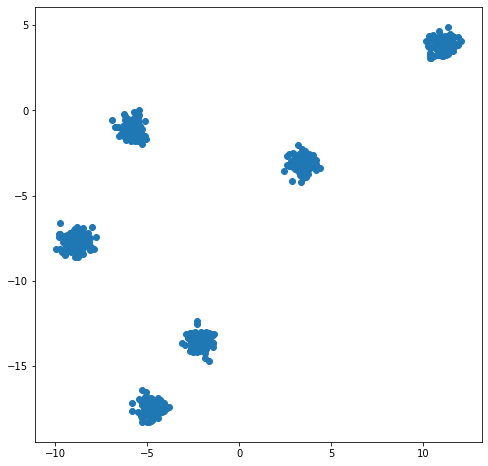

In [551]:
plt.figure(figsize= (8,8))
plt.scatter(X.detach()[:,0], X.detach()[:,1])
plt.show()

In [552]:
model = DeepGaussianMixture(idim = 15,output_dim = 2)

In [553]:
def train_bitflip(model, x, lr = 0.001, viz = True,n_epoch = 75000):
    """
    x is n x p 
    
    """
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        theta = model.compute_latents(x)
        z = torch.bernoulli(theta.detach())
        loss1 = bitflip.apply(theta,model,x,z) + model.variational_entropy(theta)
        x_hat = model.latent_to_mean(z.detach())
        loss2 = model.gauss_loss(x,x_hat)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if (epoch % 500 == 0):
            theta = model.compute_latents(x)
            z = torch.bernoulli(theta.detach())
            if viz:
                colors = {1:'red',  0:'blue'}

                fig, (ax1, ax2,ax3 ) = plt.subplots(1, 3, figsize = (15,5))

                to_plot = [colors[i] for i in np.array((z[:,0].detach() >0.5)).astype(int)]
                ax1.scatter(X.detach()[:,0], X.detach()[:,1], color = to_plot,s=1)
                to_plot = [colors[i] for i in np.array((z[:,1].detach() >0.5)).astype(int)]
                ax2.scatter(X.detach()[:,0], X.detach()[:,1], color = to_plot, s=1)
                to_plot = [colors[i] for i in np.array((z[:,2].detach() >0.5)).astype(int)]
                ax3.scatter(X.detach()[:,0], X.detach()[:,1], color = to_plot,s=1)
                plt.show()
            losses.append(loss.item())
    return losses
def train_disarm(model, x, lr = 0.001, viz = True,n_epoch = 75000):
    """
    x is n x p 
    
    """
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        theta = model.compute_latents(x)
        z = torch.bernoulli(theta.detach())
        loss1 = disarm.apply(theta,model,x) + model.variational_entropy(theta)
        x_hat = model.latent_to_mean(z.detach())
        loss2 = model.gauss_loss(x,x_hat)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if (epoch % 500 == 0):
            theta = model.compute_latents(x)
            z = torch.bernoulli(theta.detach())
            if viz:
                colors = {1:'red',  0:'blue'}

                fig, (ax1, ax2,ax3 ) = plt.subplots(1, 3, figsize = (15,5))

                to_plot = [colors[i] for i in np.array((z[:,0].detach() >0.5)).astype(int)]
                ax1.scatter(x.detach()[:,0], x.detach()[:,1], color = to_plot,s=1)
                to_plot = [colors[i] for i in np.array((z[:,1].detach() >0.5)).astype(int)]
                ax2.scatter(x.detach()[:,0], x.detach()[:,1], color = to_plot, s=1)
                to_plot = [colors[i] for i in np.array((z[:,2].detach() >0.5)).astype(int)]
                ax3.scatter(x.detach()[:,0], x.detach()[:,1], color = to_plot,s=1)
                plt.show()
            losses.append(loss.item())
    return losses

def train_ugvc(model, x, lr = 0.001, viz = True,n_epoch = 75000):
    """
    x is n x p 
    
    """
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        theta = model.compute_latents(x)
        z = torch.bernoulli(theta.detach())
        loss1 = ugvc.apply(theta,model,x) + model.variational_entropy(theta)
        x_hat = model.latent_to_mean(z.detach())
        loss2 = model.gauss_loss(x,x_hat)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if (epoch % 500 == 0):
            theta = model.compute_latents(x)
            z = torch.bernoulli(theta.detach())
            if viz:
                colors = {1:'red',  0:'blue'}

                fig, (ax1, ax2,ax3 ) = plt.subplots(1, 3, figsize = (15,5))

                to_plot = [colors[i] for i in np.array((z[:,0].detach() >0.5)).astype(int)]
                ax1.scatter(x.detach()[:,0], x.detach()[:,1], color = to_plot,s=1)
                to_plot = [colors[i] for i in np.array((z[:,1].detach() >0.5)).astype(int)]
                ax2.scatter(x.detach()[:,0], x.detach()[:,1], color = to_plot, s=1)
                to_plot = [colors[i] for i in np.array((z[:,2].detach() >0.5)).astype(int)]
                ax3.scatter(x.detach()[:,0], x.detach()[:,1], color = to_plot,s=1)
                plt.show()
            losses.append(loss.item())
    return losses

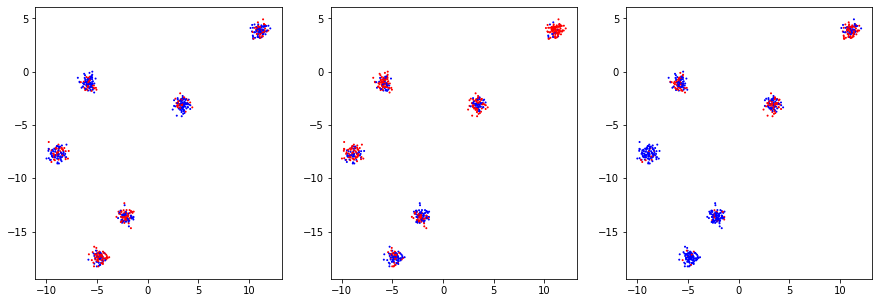

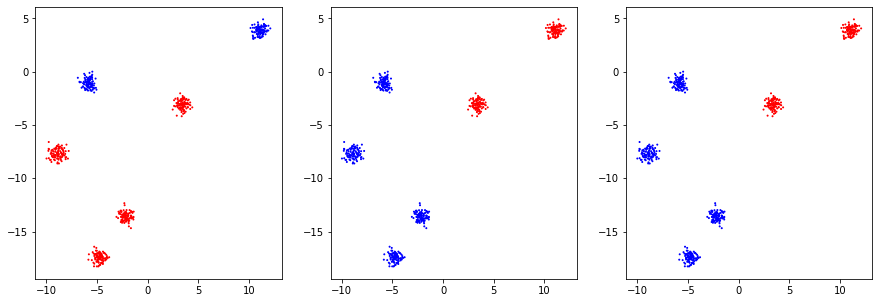

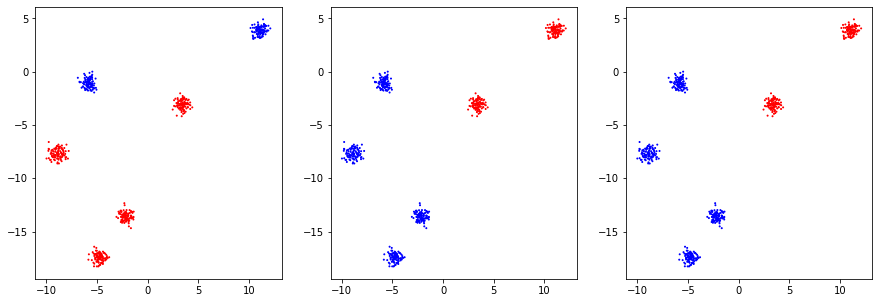

RuntimeError: python_error

In [554]:
model = DeepGaussianMixture(idim = 15,output_dim = 2)
losses_ugvc = train_ugvc(model,X, lr = 0.01,n_epoch = 10000)

In [ ]:
model = DeepGaussianMixture(idim = 15,output_dim = 2)
losses_disarm = train_disarm(model,X, lr = 0.01,n_epoch = 10000)

In [ ]:
model = DeepGaussianMixture(idim = 15,output_dim = 2)
losses_bitflip = train_bitflip(model,X, lr = 0.01, n_epoch = 10000)

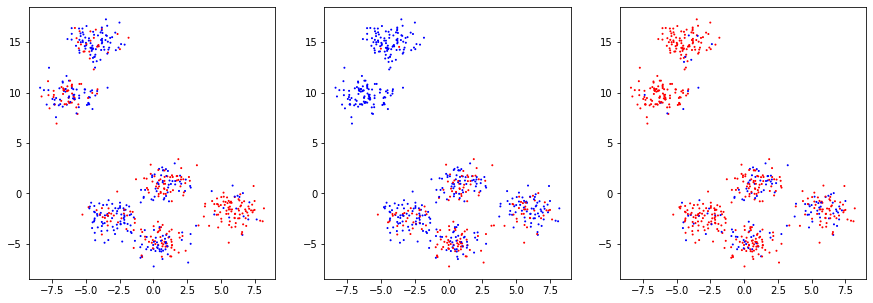

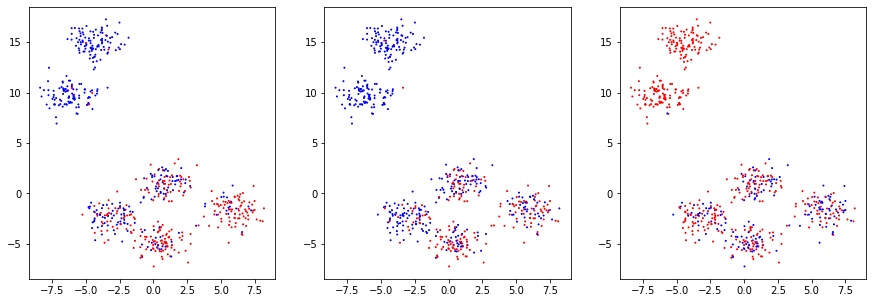

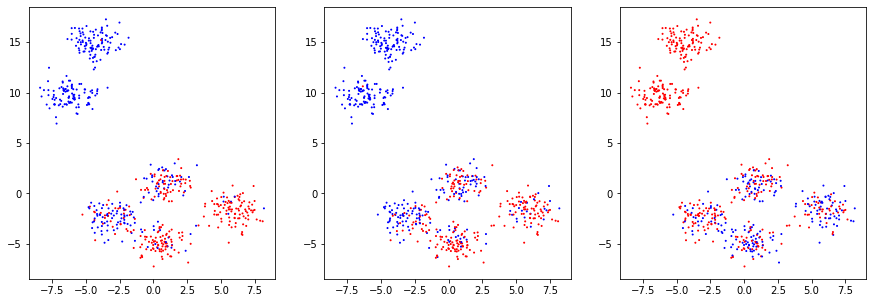

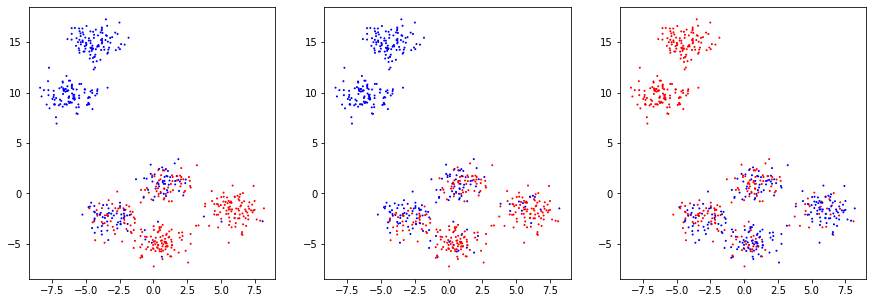

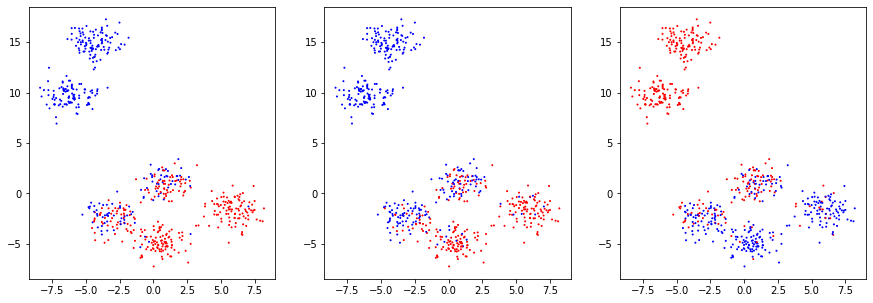

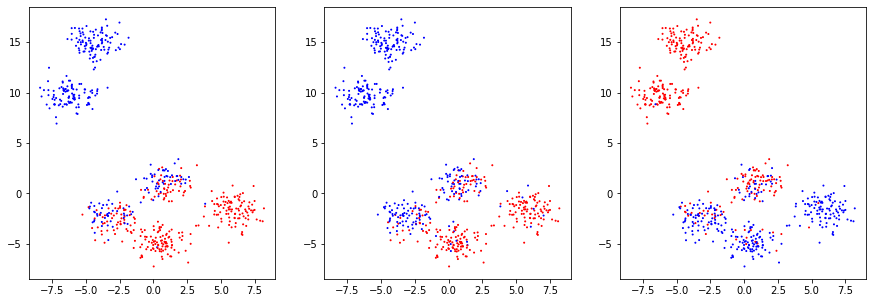

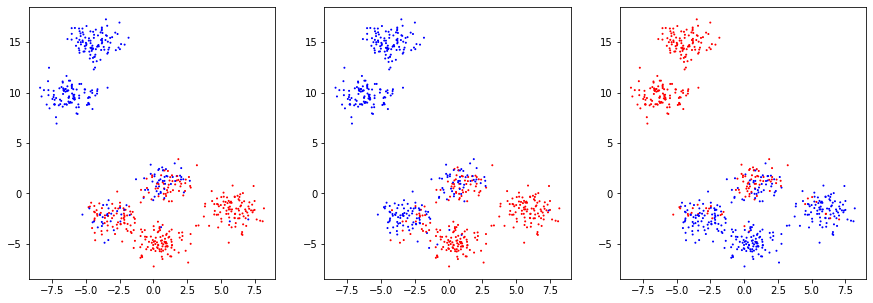

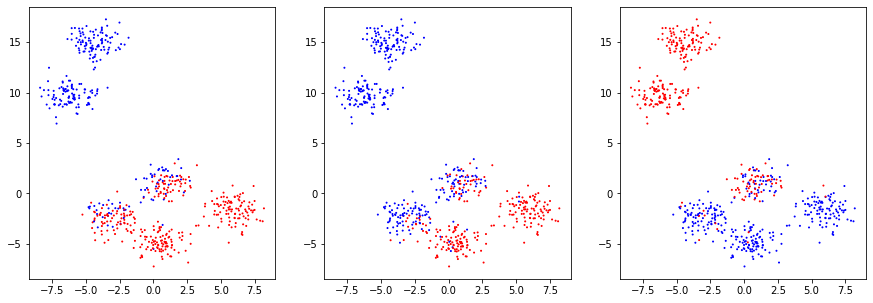

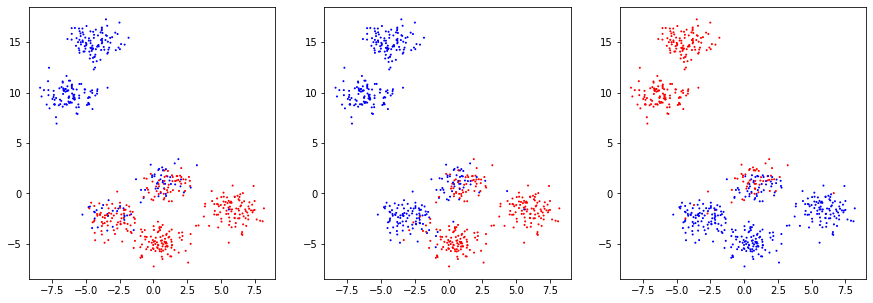

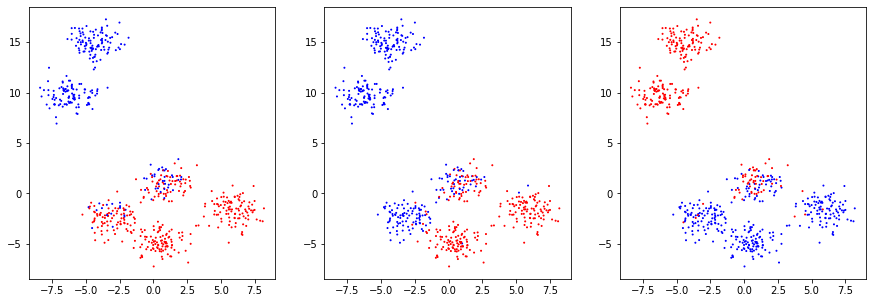

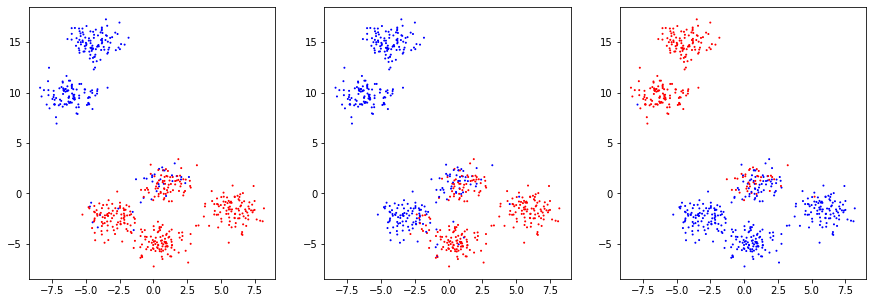

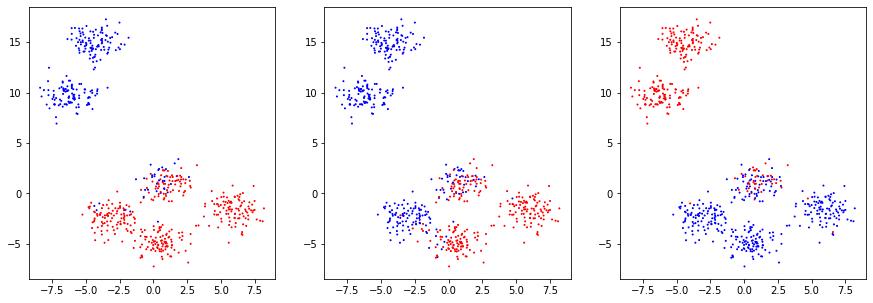

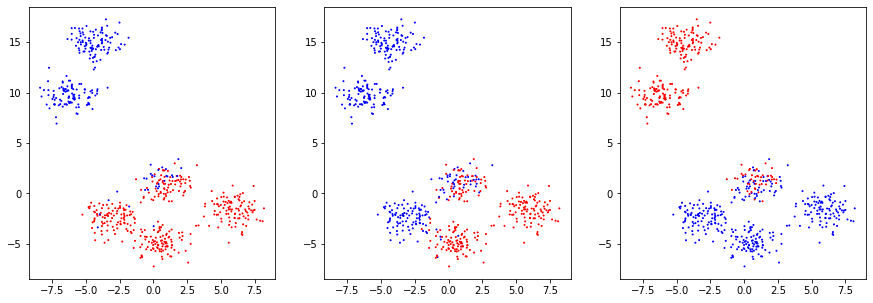

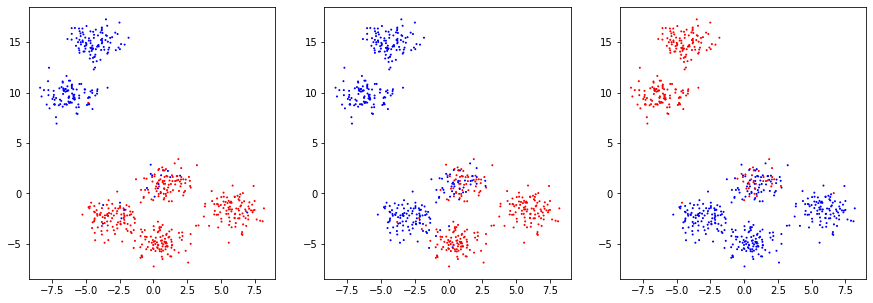

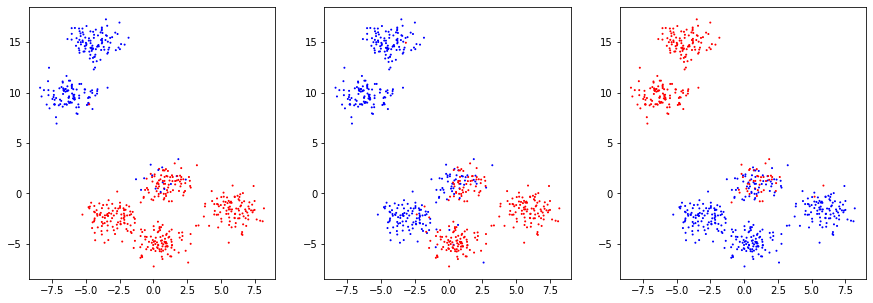

RuntimeError: python_error

In [570]:
l1 = []
l2 = []
l3 = []
for k in range(8):
    noise_level = 1.0
    K = 6
    mu = Normal(0.,8.).sample([K,2])
    X = Normal(mu[0,],noise_level).sample([100])
    for k in range(1, K):
        Xi = Normal(mu[k,:],noise_level).sample([100])
        X = torch.cat([X,Xi])
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_ugvc = train_ugvc(model,X, lr = 0.0001,n_epoch = 15000, viz = False)
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_disarm = train_disarm(model,X, lr = 0.0001,n_epoch = 15000, viz = False)
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_bitflip = train_bitflip(model,X, lr = 0.0001, n_epoch = 15000, viz = False)
    l1.append(losses_ugvc)
    l2.append(losses_disarm)
    l3.append(losses_bitflip)

In [568]:
l1 = np.array(l1)
l2 = np.array(l2)
l3 = np.array(l3)

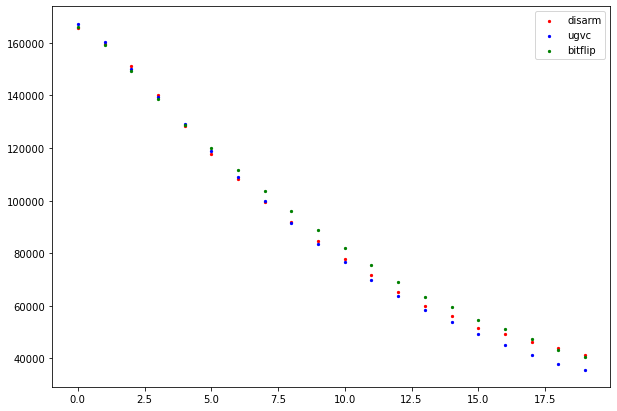

In [569]:
plt.figure(figsize = (10,7))
plt.scatter(list(range(len(losses_disarm))), l2.mean(axis = 0), s= 5, color = 'r', label = "disarm")
plt.scatter(list(range(len(losses_disarm))), l1.mean(axis = 0), s= 5, color = 'b', label = "ugvc")
plt.scatter(list(range(len(losses_disarm))), l3.mean(axis = 0), s= 5, color = 'g', label = "bitflip")
plt.legend()
plt.show()
#plt.savefig("gmm_bitflip.png", dpi = 300)

## Plot losses and variances

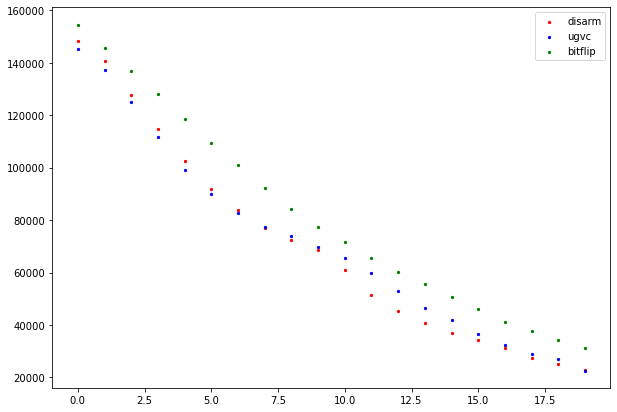

In [566]:
plt.figure(figsize = (10,7))
plt.scatter(list(range(len(losses_disarm))), losses_disarm, s= 5, color = 'r', label = "disarm")
plt.scatter(list(range(len(losses_disarm))), losses_ugvc, s= 5, color = 'b', label = "ugvc")
plt.scatter(list(range(len(losses_disarm))), losses_bitflip, s= 5, color = 'g', label = "bitflip")
plt.legend()
plt.show()

## error bars

In [ ]:
l1 = []
l2 = []
for k in range(5):
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_ugvc = train_ugvc(model,X, lr = 0.0005,n_epoch = 25000, viz = False)
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_disarm = train_disarm(model,X, lr = 0.0005,n_epoch = 25000, viz = False)
    l1.append(losses_ugvc)
    l2.append(losses_disarm)

In [364]:
l1 = []
l2 = []
for k in range(5):
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_ugvc = train_ugvc(model,X, lr = 0.0005,n_epoch = 25000, viz = False)
    model = DeepGaussianMixture(idim = 15,output_dim = 2)
    losses_disarm = train_disarm(model,X, lr = 0.0005,n_epoch = 25000, viz = False)
    l1.append(losses_ugvc)
    l2.append(losses_disarm)

In [365]:
l1 = np.array(l1)
l2 = np.array(l2)

array([198376.078125  , 131579.1609375 ,  95489.6171875 ,  61693.1453125 ,
        37274.56171875,  25993.9984375 ,  19480.88125   ,  15205.77949219,
        13464.41621094,  11912.04082031,  11684.6625    ,  11105.24140625,
        10001.60371094,  10571.81328125,  10865.15019531,  10326.44648437,
        10131.29472656,   9984.39824219,   9581.08691406,   9576.18359375,
         9879.78710938,   9955.59746094,   9937.03007813,   9385.84570312,
         9632.40546875,   9850.90371094,   9290.35097656,   9917.08417969,
         9888.79511719,   9784.21386719,  10345.04941406,   9786.14335938,
         9970.75839844,   9582.82363281,   9710.54804687,   9779.8265625 ,
         9689.40214844,   9717.57226562,   9887.20244141,   9699.21386719,
         9464.28105469,   9993.41914062,   9178.59423828,   9886.4734375 ,
         9523.05273438,   9786.18427734,   9700.83378906,   9809.46572266,
         9680.71777344,   9825.90107422])

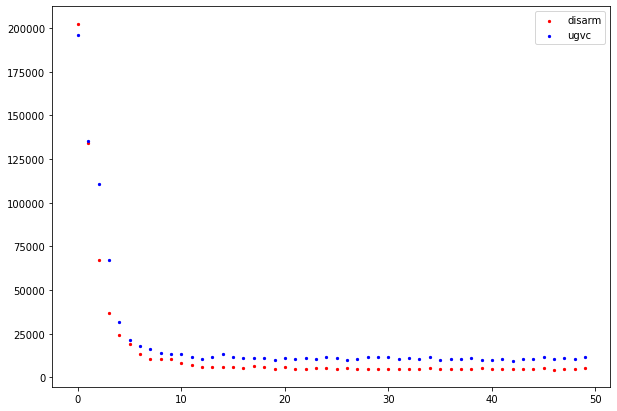

In [389]:
plt.figure(figsize = (10,7))
plt.scatter(list(range(len(losses_disarm))), l2[4], s= 5, color = 'r', label = "disarm")
plt.scatter(list(range(len(losses_disarm))), l1[4], s= 5, color = 'b', label = "ugvc")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
x = np.arange(10)
y = 2.5 * np.sin(x / 20 * np.pi)
yerr = np.linspace(0.05, 0.2, 10)

plt.errorbar(x, y + 3, yerr=yerr, label='both limits (default)')

plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')

plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
             label='uplims=True, lolims=True')

upperlimits = [True, False] * 5
lowerlimits = [False, True] * 5
plt.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits,
             label='subsets of uplims and lolims')

plt.legend(loc='lower right')

## Visualization

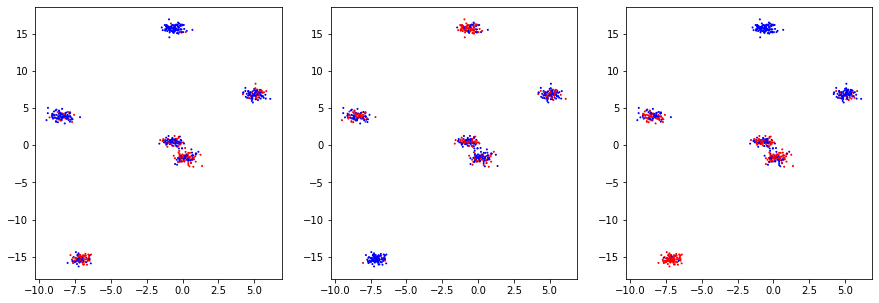

In [192]:
theta = model.compute_latents(X)
z = torch.bernoulli(theta.detach())
colors = {1:'red',  0:'blue'}

fig, (ax1, ax2,ax3 ) = plt.subplots(1, 3, figsize = (15,5))

to_plot = [colors[i] for i in np.array((z[:,0].detach() >0.5)).astype(int)]
ax1.scatter(X.detach()[:,0], X.detach()[:,1], color = to_plot,s=1)
to_plot = [colors[i] for i in np.array((z[:,1].detach() >0.5)).astype(int)]
ax2.scatter(X.detach()[:,0], X.detach()[:,1], color = to_plot, s=1)
to_plot = [colors[i] for i in np.array((z[:,2].detach() >0.5)).astype(int)]
ax3.scatter(X.detach()[:,0], X.detach()[:,1], color = to_plot,s=1)
plt.show()